# **Requirements**

In [2]:
import numpy as np 
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
from pydub import AudioSegment
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, f1_score, precision_score, recall_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# **Change the format of the input**

In [25]:
!git clone https://github.com/liucht4212/AI_project1.git

Cloning into 'AI_project1'...
remote: Enumerating objects: 342, done.
remote: Counting objects: 100% (342/342), done.
remote: Compressing objects: 100% (338/338), done.
remote: Total 342 (delta 2), reused 339 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (342/342), 7.15 MiB | 17.69 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [29]:
input_folder = "AI_project1"
output_folder = "processed_dataset"

for category in ["voiced", "voiceless"]:
    os.makedirs(f"{output_folder}/{category}", exist_ok=True)
    for file in os.listdir(f"{input_folder}/{category}"):
        if file.endswith(".mp3"):
            audio = AudioSegment.from_mp3(f"{input_folder}/{category}/{file}")
            audio = audio.set_frame_rate(16000).set_channels(1)  
            audio.export(f"{output_folder}/{category}/{file.replace('.mp3', '.wav')}", format="wav")

# **Feature Extraction**

In [4]:
dataset_folder = "processed_dataset"
np.random.seed(42)
X_mfcc = []  
y_mfcc = []
X_zcr = []
y_zcr = []
X_mel = []
y_mel = []
X_contrast = []
y_contrast = [] 

for label, category in enumerate(["voiceless", "voiced"]):
    for file in os.listdir(f"{dataset_folder}/{category}"):
        if file.endswith(".wav"):
            y, sr = librosa.load(f"{dataset_folder}/{category}/{file}", sr=16000)
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
            mfccs_mean = np.mean(mfccs, axis=1) 
            X_mfcc.append(mfccs_mean)
            y_mfcc.append(label)
            
            zcr = librosa.feature.zero_crossing_rate(y=y)
            zcr_mean = np.mean(zcr, axis=1)
            X_zcr.append(zcr_mean)
            y_zcr.append(label)
            
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40)
            mel_spec_db = librosa.power_to_db(mel_spec)
            mel_mean = np.mean(mel_spec_db, axis=1)
            X_mel.append(mel_mean)
            y_mel.append(label)
            

X_mfcc = np.array(X_mfcc)
y_mfcc = np.array(y_mfcc)
X_zcr = np.array(X_zcr)
y_zcr = np.array(y_zcr)
X_mel = np.array(X_mel)
y_mel = np.array(y_mel)

# **Supervised learning-MFCC**

In [5]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svm_model = SVC(kernel="linear", probability=True, random_state=42)
metrics = {"accuracy": [], "roc_auc": [], "f1": [],"precision": [], "recall": []}

for train_idx, test_idx in cv.split(X_mfcc, y_mfcc):
    X_train, X_test = X_mfcc[train_idx], X_mfcc[test_idx]
    y_train, y_test = y_mfcc[train_idx], y_mfcc[test_idx]
    svm_model.fit(X_train, y_train)
    y_pred = svm_model.predict(X_test)
    y_proba = svm_model.predict_proba(X_test)[:, 1]
    metrics["accuracy"].append(accuracy_score(y_test, y_pred))
    metrics["roc_auc"].append(roc_auc_score(y_test, y_proba))
    metrics["f1"].append(f1_score(y_test, y_pred))
    metrics["precision"].append(precision_score(y_test, y_pred, zero_division=0))
    metrics["recall"].append(recall_score(y_test, y_pred))

svm_performance_mfcc = {metric: {"mean": np.mean(values), "std": np.std(values)} for metric, values in metrics.items()}
print("===== SVM Cross-Validation Performance =====")
for metric, values in svm_performance_mfcc.items():
    print(f"  {metric.upper()}: {values['mean']:.6f} ± {values['std']:.6f}")

===== SVM Cross-Validation Performance =====
  ACCURACY: 0.647646 ± 0.066384
  ROC_AUC: 0.708722 ± 0.047475
  F1: 0.512667 ± 0.089387
  PRECISION: 0.592183 ± 0.109119
  RECALL: 0.455840 ± 0.086019


In [6]:
# Random Forest Model
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_model = RandomForestClassifier(n_estimators=45, max_depth=5, random_state=42)
metrics = {"accuracy": [], "roc_auc": [], "f1": [],"precision": [], "recall": []}

for train_idx, test_idx in cv.split(X_mfcc, y_mfcc):
    X_train, X_test = X_mfcc[train_idx], X_mfcc[test_idx]
    y_train, y_test = y_mfcc[train_idx], y_mfcc[test_idx]
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    y_proba = rf_model.predict_proba(X_test)[:, 1]
    metrics["accuracy"].append(accuracy_score(y_test, y_pred))
    metrics["roc_auc"].append(roc_auc_score(y_test, y_proba))
    metrics["f1"].append(f1_score(y_test, y_pred))
    metrics["precision"].append(precision_score(y_test, y_pred, zero_division=0))
    metrics["recall"].append(recall_score(y_test, y_pred))

rf_performance_mfcc = {metric: {"mean": np.mean(values), "std": np.std(values)} for metric, values in metrics.items()}
print("===== Random Forest Performance =====")
for metric, values in rf_performance_mfcc.items():
    print(f"  {metric.upper()}: {values['mean']:.6f} ± {values['std']:.6f}")

===== Random Forest Performance =====
  ACCURACY: 0.635245 ± 0.030386
  ROC_AUC: 0.683374 ± 0.079146
  F1: 0.459060 ± 0.041272
  PRECISION: 0.586670 ± 0.073045
  RECALL: 0.381197 ± 0.048664


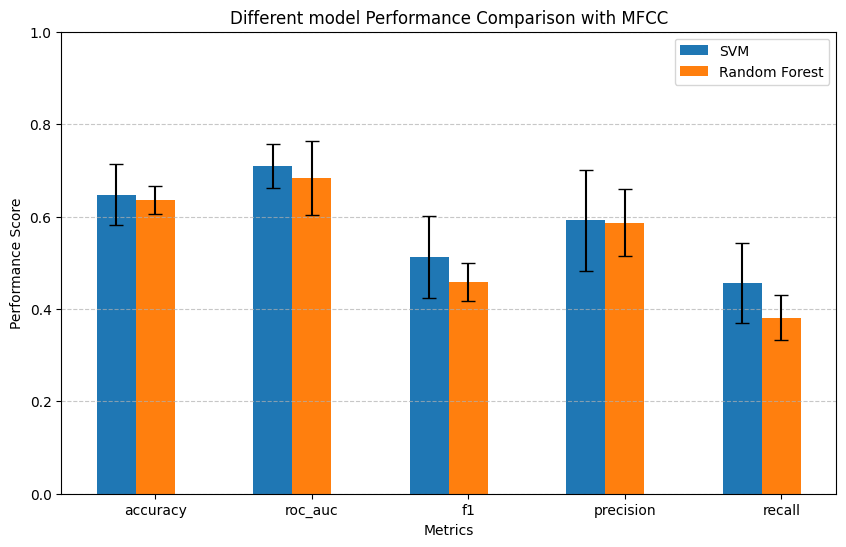

In [7]:
#comparison with two model
metrics = ["accuracy", "roc_auc", "f1", "precision", "recall"]
features = ["SVM", "Random Forest"]

means = np.array([
    [svm_performance_mfcc[m]["mean"] for m in metrics],
    [rf_performance_mfcc[m]["mean"] for m in metrics],
])
stds = np.array([
    [svm_performance_mfcc[m]["std"] for m in metrics],
    [rf_performance_mfcc[m]["std"] for m in metrics],
])

x = np.arange(len(metrics))
width = 0.25
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(len(features)):
    ax.bar(x + i * width, means[i], width, label=features[i], yerr=stds[i], capsize=5)

ax.set_xlabel("Metrics")
ax.set_ylabel("Performance Score")
ax.set_title("Different model Performance Comparison with MFCC")
ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.legend()
plt.ylim(0.0, 1.0) 
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


# **Supervised learning-Mel spectrogram**

In [8]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svm_model = SVC(kernel="linear", probability=True, random_state=42)
metrics = {"accuracy": [], "roc_auc": [], "f1": [],"precision": [], "recall": []}

for train_idx, test_idx in cv.split(X_mel, y_mel):
    X_train, X_test = X_mel[train_idx], X_mel[test_idx]
    y_train, y_test = y_mel[train_idx], y_mel[test_idx]
    svm_model.fit(X_train, y_train)
    y_pred = svm_model.predict(X_test)
    y_proba = svm_model.predict_proba(X_test)[:, 1]
    metrics["accuracy"].append(accuracy_score(y_test, y_pred))
    metrics["roc_auc"].append(roc_auc_score(y_test, y_proba))
    metrics["f1"].append(f1_score(y_test, y_pred))
    metrics["precision"].append(precision_score(y_test, y_pred, zero_division=0))
    metrics["recall"].append(recall_score(y_test, y_pred))

svm_performance_mel = {metric: {"mean": np.mean(values), "std": np.std(values)} for metric, values in metrics.items()}
print("===== SVM Cross-Validation Performance =====")
for metric, values in svm_performance_mel.items():
    print(f"  {metric.upper()}: {values['mean']:.6f} ± {values['std']:.6f}")

===== SVM Cross-Validation Performance =====
  ACCURACY: 0.680699 ± 0.036062
  ROC_AUC: 0.745803 ± 0.037941
  F1: 0.577900 ± 0.049082
  PRECISION: 0.626252 ± 0.057054
  RECALL: 0.536752 ± 0.044305


In [9]:
# Random Forest Model
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_model = RandomForestClassifier(n_estimators=45, max_depth=5, random_state=42)
metrics = {"accuracy": [], "roc_auc": [], "f1": [],"precision": [], "recall": []}

for train_idx, test_idx in cv.split(X_mel, y_mel):
    X_train, X_test = X_mel[train_idx], X_mel[test_idx]
    y_train, y_test = y_mel[train_idx], y_mel[test_idx]
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    y_proba = rf_model.predict_proba(X_test)[:, 1]
    metrics["accuracy"].append(accuracy_score(y_test, y_pred))
    metrics["roc_auc"].append(roc_auc_score(y_test, y_proba))
    metrics["f1"].append(f1_score(y_test, y_pred))
    metrics["precision"].append(precision_score(y_test, y_pred, zero_division=0))
    metrics["recall"].append(recall_score(y_test, y_pred))

rf_performance_mel = {metric: {"mean": np.mean(values), "std": np.std(values)} for metric, values in metrics.items()}
print("===== Random Forest Performance =====")
for metric, values in rf_performance_mel.items():
    print(f"  {metric.upper()}: {values['mean']:.6f} ± {values['std']:.6f}")

===== Random Forest Performance =====
  ACCURACY: 0.680466 ± 0.079397
  ROC_AUC: 0.706202 ± 0.101958
  F1: 0.552525 ± 0.125471
  PRECISION: 0.636733 ± 0.115705
  RECALL: 0.498860 ± 0.148379


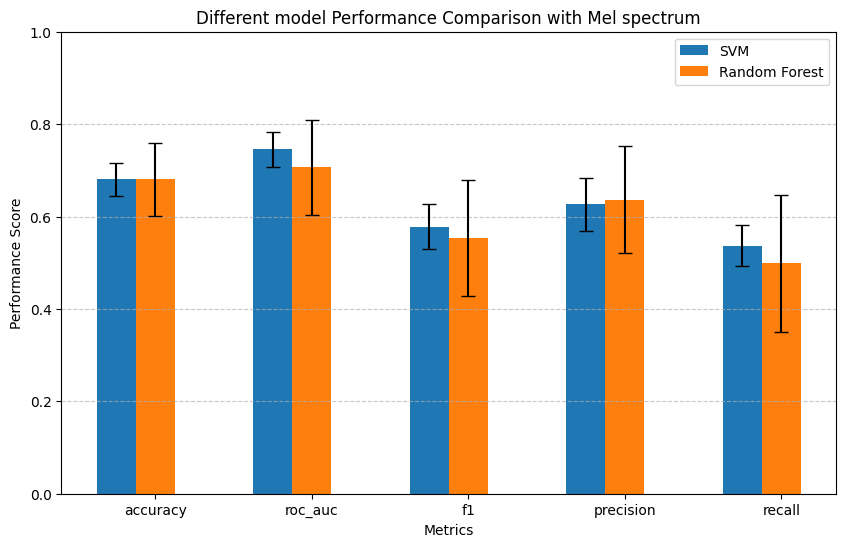

In [10]:
#comparison with two model
metrics = ["accuracy", "roc_auc", "f1", "precision", "recall"]
features = ["SVM", "Random Forest"]

means = np.array([
    [svm_performance_mel[m]["mean"] for m in metrics],
    [rf_performance_mel[m]["mean"] for m in metrics],
])
stds = np.array([
    [svm_performance_mel[m]["std"] for m in metrics],
    [rf_performance_mel[m]["std"] for m in metrics],
])

x = np.arange(len(metrics))
width = 0.25
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(len(features)):
    ax.bar(x + i * width, means[i], width, label=features[i], yerr=stds[i], capsize=5)

ax.set_xlabel("Metrics")
ax.set_ylabel("Performance Score")
ax.set_title("Different model Performance Comparison with Mel spectrum")
ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.legend()
plt.ylim(0.0, 1.0) 
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


# **Supervised learning-Zero crossing rate**

In [11]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svm_model = SVC(kernel="linear", probability=True, random_state=42)
metrics = {"accuracy": [], "roc_auc": [], "f1": [],"precision": [], "recall": []}

for train_idx, test_idx in cv.split(X_zcr, y_zcr):
    X_train, X_test = X_zcr[train_idx], X_zcr[test_idx]
    y_train, y_test = y_zcr[train_idx], y_zcr[test_idx]
    svm_model.fit(X_train, y_train)
    y_pred = svm_model.predict(X_test)
    y_proba = svm_model.predict_proba(X_test)[:, 1]
    metrics["accuracy"].append(accuracy_score(y_test, y_pred))
    metrics["roc_auc"].append(roc_auc_score(y_test, y_proba))
    metrics["f1"].append(f1_score(y_test, y_pred))
    metrics["precision"].append(precision_score(y_test, y_pred, zero_division=0))
    metrics["recall"].append(recall_score(y_test, y_pred))

svm_performance_zcr = {metric: {"mean": np.mean(values), "std": np.std(values)} for metric, values in metrics.items()}
print("===== SVM Cross-Validation Performance =====")
for metric, values in svm_performance_zcr.items():
    print(f"  {metric.upper()}: {values['mean']:.6f} ± {values['std']:.6f}")

===== SVM Cross-Validation Performance =====
  ACCURACY: 0.592727 ± 0.003636
  ROC_AUC: 0.464892 ± 0.045875
  F1: 0.000000 ± 0.000000
  PRECISION: 0.000000 ± 0.000000
  RECALL: 0.000000 ± 0.000000


In [12]:
# Random Forest Model
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_model = RandomForestClassifier(n_estimators=45, max_depth=5, random_state=42)
metrics = {"accuracy": [], "roc_auc": [], "f1": [],"precision": [], "recall": []}

for train_idx, test_idx in cv.split(X_zcr, y_zcr):
    X_train, X_test = X_zcr[train_idx], X_zcr[test_idx]
    y_train, y_test = y_zcr[train_idx], y_zcr[test_idx]
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    y_proba = rf_model.predict_proba(X_test)[:, 1]
    metrics["accuracy"].append(accuracy_score(y_test, y_pred))
    metrics["roc_auc"].append(roc_auc_score(y_test, y_proba))
    metrics["f1"].append(f1_score(y_test, y_pred))
    metrics["precision"].append(precision_score(y_test, y_pred, zero_division=0))
    metrics["recall"].append(recall_score(y_test, y_pred))

rf_performance_zcr = {metric: {"mean": np.mean(values), "std": np.std(values)} for metric, values in metrics.items()}
print("===== Random Forest Performance =====")
for metric, values in rf_performance_zcr.items():
    print(f"  {metric.upper()}: {values['mean']:.6f} ± {values['std']:.6f}")

===== Random Forest Performance =====
  ACCURACY: 0.650396 ± 0.022317
  ROC_AUC: 0.654778 ± 0.022055
  F1: 0.509651 ± 0.030016
  PRECISION: 0.598936 ± 0.051912
  RECALL: 0.447293 ± 0.042487


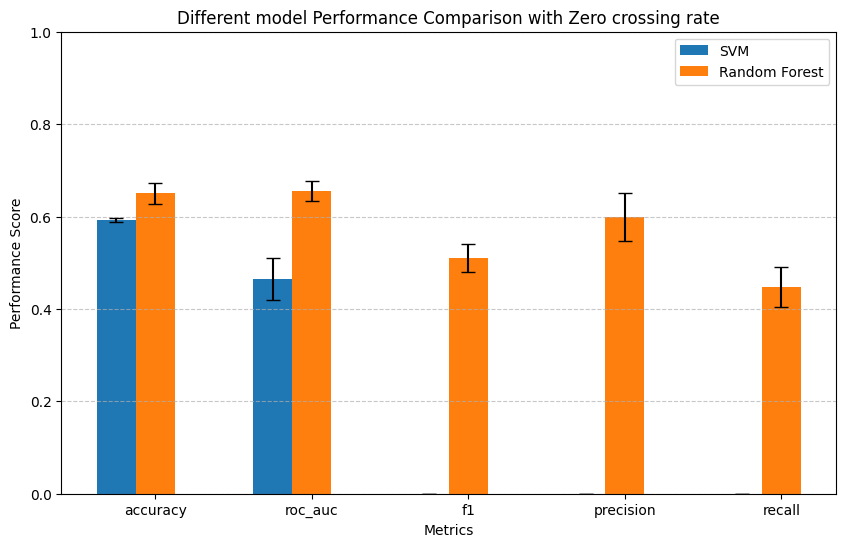

In [13]:
#comparison with two model
metrics = ["accuracy", "roc_auc", "f1", "precision", "recall"]
features = ["SVM", "Random Forest"]

means = np.array([
    [svm_performance_zcr[m]["mean"] for m in metrics],
    [rf_performance_zcr[m]["mean"] for m in metrics],
])
stds = np.array([
    [svm_performance_zcr[m]["std"] for m in metrics],
    [rf_performance_zcr[m]["std"] for m in metrics],
])

x = np.arange(len(metrics))
width = 0.25
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(len(features)):
    ax.bar(x + i * width, means[i], width, label=features[i], yerr=stds[i], capsize=5)

ax.set_xlabel("Metrics")
ax.set_ylabel("Performance Score")
ax.set_title("Different model Performance Comparison with Zero crossing rate")
ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.legend()
plt.ylim(0.0, 1.0) 
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


# **Different Feature Extraction comparison**

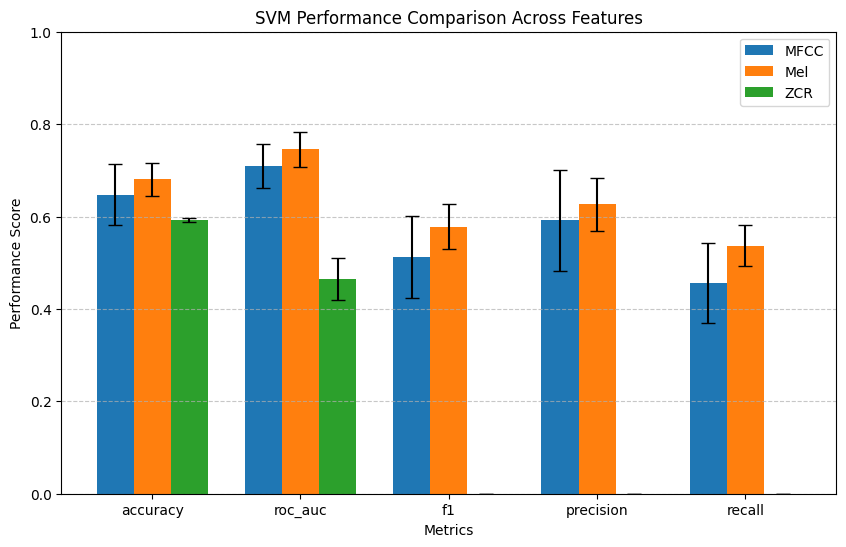

In [14]:
metrics = ["accuracy", "roc_auc", "f1", "precision", "recall"]
features = ["MFCC", "Mel", "ZCR"]

means = np.array([
    [svm_performance_mfcc[m]["mean"] for m in metrics],
    [svm_performance_mel[m]["mean"] for m in metrics],
    [svm_performance_zcr[m]["mean"] for m in metrics],
])
stds = np.array([
    [svm_performance_mfcc[m]["std"] for m in metrics],
    [svm_performance_mel[m]["std"] for m in metrics],
    [svm_performance_zcr[m]["std"] for m in metrics],
])


x = np.arange(len(metrics))
width = 0.25
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(len(features)):
    ax.bar(x + i * width, means[i], width, label=features[i], yerr=stds[i], capsize=5)

ax.set_xlabel("Metrics")
ax.set_ylabel("Performance Score")
ax.set_title("SVM Performance Comparison Across Features")
ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.legend()
plt.ylim(0.0, 1.0) 
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

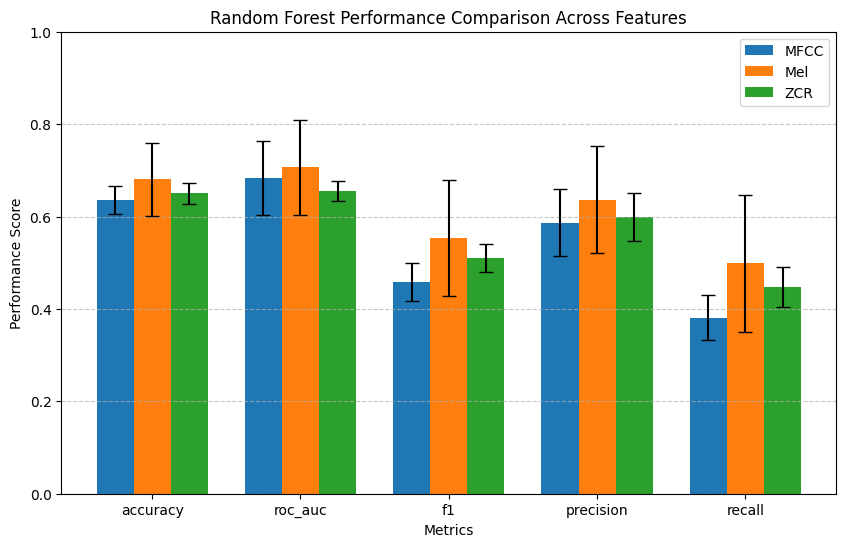

In [15]:
metrics = ["accuracy", "roc_auc", "f1", "precision", "recall"]
features = ["MFCC", "Mel", "ZCR"]

means = np.array([
    [rf_performance_mfcc[m]["mean"] for m in metrics],
    [rf_performance_mel[m]["mean"] for m in metrics],
    [rf_performance_zcr[m]["mean"] for m in metrics],
])
stds = np.array([
    [rf_performance_mfcc[m]["std"] for m in metrics],
    [rf_performance_mel[m]["std"] for m in metrics],
    [rf_performance_zcr[m]["std"] for m in metrics],
])


x = np.arange(len(metrics))
width = 0.25
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(len(features)):
    ax.bar(x + i * width, means[i], width, label=features[i], yerr=stds[i], capsize=5)

ax.set_xlabel("Metrics")
ax.set_ylabel("Performance Score")
ax.set_title("Random Forest Performance Comparison Across Features")
ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.legend()
plt.ylim(0.0, 1.0) 
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# **Experiment - train set**

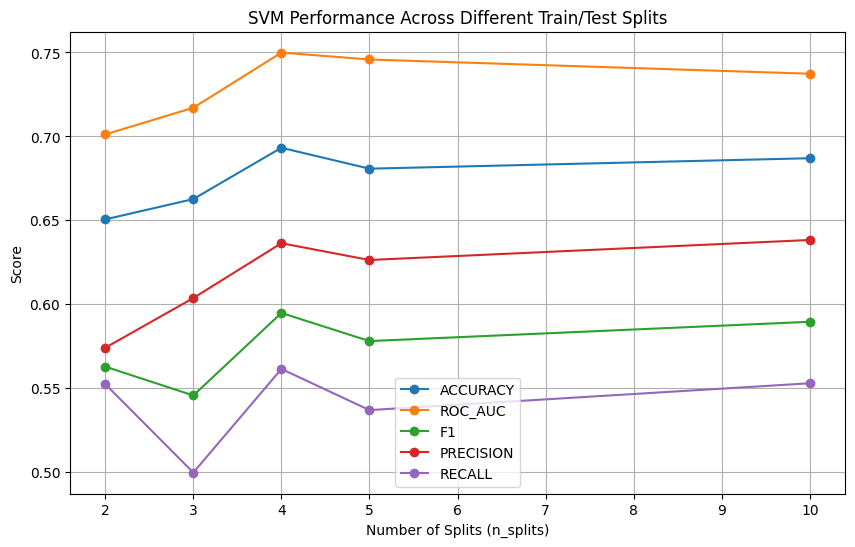

In [16]:
splits = [2, 3, 4, 5, 10] 
results = {metric: [] for metric in ["accuracy", "roc_auc", "f1", "precision", "recall"]}

for n_splits in splits:
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    svm_model = SVC(kernel="linear", probability=True, random_state=42)
    metrics = {metric: [] for metric in results.keys()}

    for train_idx, test_idx in cv.split(X_mel, y_mel):
        X_train, X_test = np.array(X_mel)[train_idx], np.array(X_mel)[test_idx]
        y_train, y_test = np.array(y_mel)[train_idx], np.array(y_mel)[test_idx]
        
        svm_model.fit(X_train, y_train)
        y_pred = svm_model.predict(X_test)
        y_proba = svm_model.predict_proba(X_test)[:, 1]
        
        metrics["accuracy"].append(accuracy_score(y_test, y_pred))
        metrics["roc_auc"].append(roc_auc_score(y_test, y_proba))
        metrics["f1"].append(f1_score(y_test, y_pred))
        metrics["precision"].append(precision_score(y_test, y_pred, zero_division=0))
        metrics["recall"].append(recall_score(y_test, y_pred))

    for metric in metrics:
        results[metric].append(np.mean(metrics[metric]))

plt.figure(figsize=(10, 6))
for metric, values in results.items():
    plt.plot(splits, values, marker="o", label=metric.upper())

plt.xlabel("Number of Splits (n_splits)")
plt.ylabel("Score")
plt.title("SVM Performance Across Different Train/Test Splits")
plt.legend()
plt.grid(True)
plt.show()

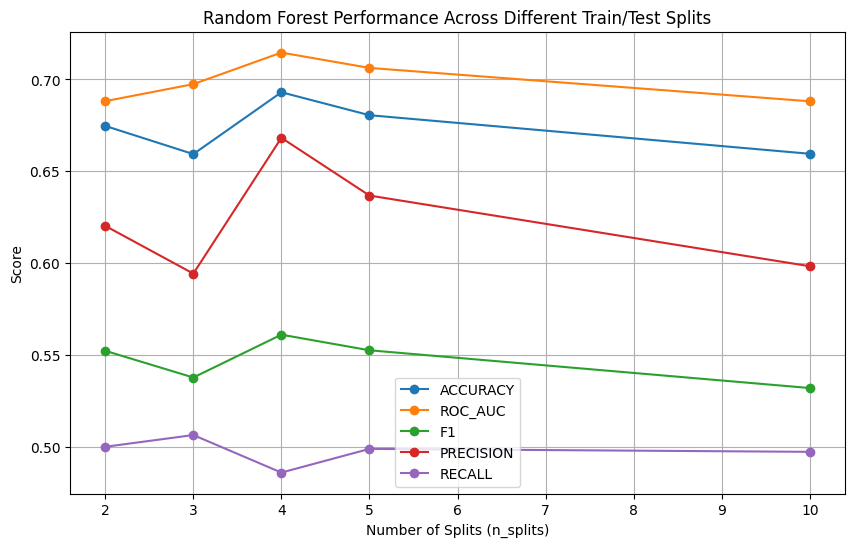

In [17]:
splits = [2, 3, 4, 5, 10] 
results = {metric: [] for metric in ["accuracy", "roc_auc", "f1", "precision", "recall"]}

for n_splits in splits:
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    rf_model = RandomForestClassifier(n_estimators=45, max_depth=5, random_state=42)
    metrics = {metric: [] for metric in results.keys()}

    for train_idx, test_idx in cv.split(X_mel, y_mel):
        X_train, X_test = np.array(X_mel)[train_idx], np.array(X_mel)[test_idx]
        y_train, y_test = np.array(y_mel)[train_idx], np.array(y_mel)[test_idx]
        
        rf_model.fit(X_train, y_train)
        y_pred = rf_model.predict(X_test)
        y_proba = rf_model.predict_proba(X_test)[:, 1]
        
        metrics["accuracy"].append(accuracy_score(y_test, y_pred))
        metrics["roc_auc"].append(roc_auc_score(y_test, y_proba))
        metrics["f1"].append(f1_score(y_test, y_pred))
        metrics["precision"].append(precision_score(y_test, y_pred, zero_division=0))
        metrics["recall"].append(recall_score(y_test, y_pred))

    for metric in metrics:
        results[metric].append(np.mean(metrics[metric]))

plt.figure(figsize=(10, 6))
for metric, values in results.items():
    plt.plot(splits, values, marker="o", label=metric.upper())

plt.xlabel("Number of Splits (n_splits)")
plt.ylabel("Score")
plt.title("Random Forest Performance Across Different Train/Test Splits")
plt.legend()
plt.grid(True)
plt.show()

# **Experiment - imbalance processing**

In [18]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svm_model = SVC(kernel="linear", probability=True, random_state=42, class_weight="balanced", C=10)
metrics = {"accuracy": [], "roc_auc": [], "f1": [],"precision": [], "recall": []}

for train_idx, test_idx in cv.split(X_zcr, y_zcr):
    X_train, X_test = X_zcr[train_idx], X_zcr[test_idx]
    y_train, y_test = y_zcr[train_idx], y_zcr[test_idx]
    svm_model.fit(X_train, y_train)
    y_pred = svm_model.predict(X_test)
    y_proba = svm_model.predict_proba(X_test)[:, 1]
    metrics["accuracy"].append(accuracy_score(y_test, y_pred))
    metrics["roc_auc"].append(roc_auc_score(y_test, y_proba))
    metrics["f1"].append(f1_score(y_test, y_pred))
    metrics["precision"].append(precision_score(y_test, y_pred, zero_division=0))
    metrics["recall"].append(recall_score(y_test, y_pred))

svm_performance_zcr_balance = {metric: {"mean": np.mean(values), "std": np.std(values)} for metric, values in metrics.items()}
print("===== SVM Cross-Validation Performance =====")
for metric, values in svm_performance_zcr_balance.items():
    print(f"  {metric.upper()}: {values['mean']:.6f} ± {values['std']:.6f}")

===== SVM Cross-Validation Performance =====
  ACCURACY: 0.492308 ± 0.029656
  ROC_AUC: 0.464892 ± 0.045875
  F1: 0.577384 ± 0.016706
  PRECISION: 0.437347 ± 0.018216
  RECALL: 0.850712 ± 0.023535


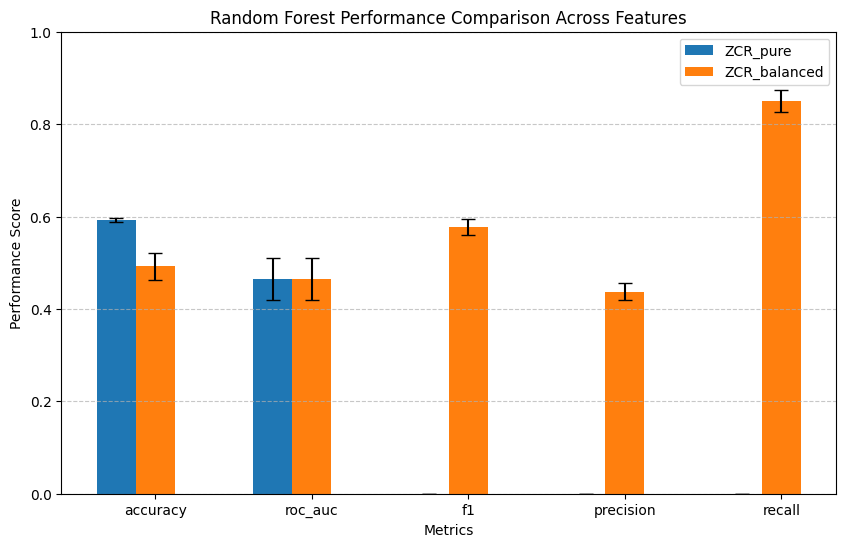

In [19]:
metrics = ["accuracy", "roc_auc", "f1", "precision", "recall"]
features = ["ZCR_pure", "ZCR_balanced"]

means = np.array([
    [svm_performance_zcr[m]["mean"] for m in metrics],
    [svm_performance_zcr_balance[m]["mean"] for m in metrics],
])
stds = np.array([
    [svm_performance_zcr[m]["std"] for m in metrics],
    [svm_performance_zcr_balance[m]["std"] for m in metrics],
])


x = np.arange(len(metrics))
width = 0.25
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(len(features)):
    ax.bar(x + i * width, means[i], width, label=features[i], yerr=stds[i], capsize=5)

ax.set_xlabel("Metrics")
ax.set_ylabel("Performance Score")
ax.set_title("Random Forest Performance Comparison Across Features")
ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.legend()
plt.ylim(0.0, 1.0) 
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [20]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_model = RandomForestClassifier( n_estimators=45, max_depth=5, class_weight="balanced", random_state=42)
metrics = {"accuracy": [], "roc_auc": [], "f1": [], "precision": [], "recall": []}

for train_idx, test_idx in cv.split(X_zcr, y_zcr):
    X_train, X_test = np.array(X_zcr)[train_idx], np.array(X_zcr)[test_idx]
    y_train, y_test = np.array(y_zcr)[train_idx], np.array(y_zcr)[test_idx]
    
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    y_proba = rf_model.predict_proba(X_test)[:, 1]
    
    metrics["accuracy"].append(accuracy_score(y_test, y_pred))
    metrics["roc_auc"].append(roc_auc_score(y_test, y_proba))
    metrics["f1"].append(f1_score(y_test, y_pred))
    metrics["precision"].append(precision_score(y_test, y_pred, zero_division=0))
    metrics["recall"].append(recall_score(y_test, y_pred))

rf_performance_zcr_balanced = {metric: {"mean": np.mean(values), "std": np.std(values)} for metric, values in metrics.items()}

print("===== Balanced Random Forest Performance =====")
for metric, values in rf_performance_zcr_balanced.items():
    print(f"  {metric.upper()}: {values['mean']:.6f} ± {values['std']:.6f}")


===== Balanced Random Forest Performance =====
  ACCURACY: 0.598741 ± 0.033082
  ROC_AUC: 0.655070 ± 0.016775
  F1: 0.550488 ± 0.038670
  PRECISION: 0.506520 ± 0.034639
  RECALL: 0.604274 ± 0.051538


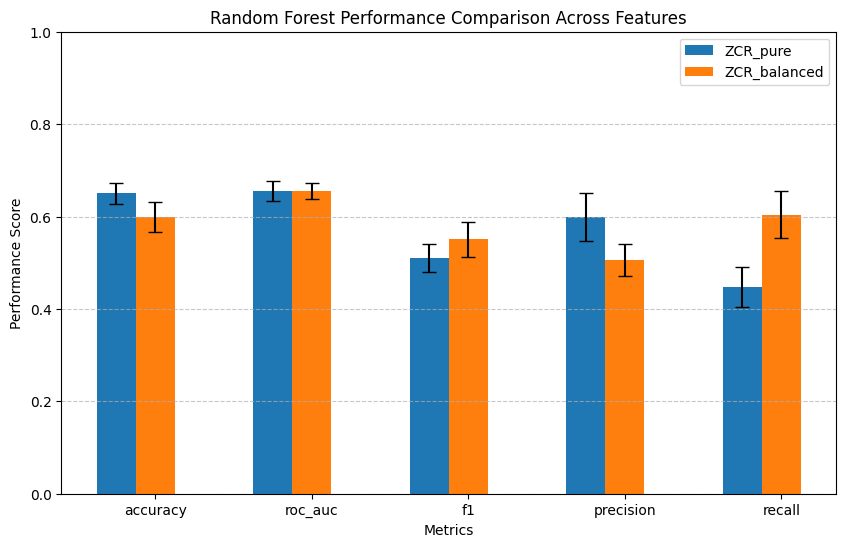

In [21]:
metrics = ["accuracy", "roc_auc", "f1", "precision", "recall"]
features = ["ZCR_pure", "ZCR_balanced"]

means = np.array([
    [rf_performance_zcr[m]["mean"] for m in metrics],
    [rf_performance_zcr_balanced[m]["mean"] for m in metrics],
])
stds = np.array([
    [rf_performance_zcr[m]["std"] for m in metrics],
    [rf_performance_zcr_balanced[m]["std"] for m in metrics],
])


x = np.arange(len(metrics))
width = 0.25
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(len(features)):
    ax.bar(x + i * width, means[i], width, label=features[i], yerr=stds[i], capsize=5)

ax.set_xlabel("Metrics")
ax.set_ylabel("Performance Score")
ax.set_title("Random Forest Performance Comparison Across Features")
ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.legend()
plt.ylim(0.0, 1.0) 
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# **Unsupervised learning**

In [22]:
def kmeans_clustering_PCA(X, y, feature_name):
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=5)
    clusters = kmeans.fit_predict(X)
    
    acc1 = accuracy_score(y, clusters)
    acc2 = accuracy_score(y, 1 - clusters)
    best_acc = max(acc1, acc2)
    print(f"K-Means Clustering Accuracy ({feature_name}): {best_acc:.4f}")
    
    #PCA Reduce dimensionality 
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    # Original labels
    scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="viridis", alpha=0.7)
    axes[0].set_xlabel("PCA Original Component 1")
    axes[0].set_ylabel("PCA Original Component 2")
    axes[0].set_title(f"Original Data Distribution ({feature_name})")
    fig.colorbar(scatter1, ax=axes[0], label="True Label")

    # K-Means clustering results
    scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap="coolwarm", alpha=0.7)
    axes[1].set_xlabel("PCA K-means Component 1")
    axes[1].set_ylabel("PCA K-means Component 2")
    axes[1].set_title(f"K-Means Clustering ({feature_name})")
    fig.colorbar(scatter2, ax=axes[1], label="Cluster Label")
    plt.tight_layout()
    plt.show()
    
    return best_acc

In [23]:
def kmeans_clustering_ZCR(X, y):
    
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=5)
    clusters = kmeans.fit_predict(X)

    acc1 = accuracy_score(y, clusters)
    acc2 = accuracy_score(y, 1 - clusters)
    best_acc = max(acc1, acc2)
    print(f"K-Means Clustering Accuracy (ZCR): {best_acc:.4f}")

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].scatter(X, np.zeros_like(X), c=y, cmap="viridis", alpha=0.7)
    axes[0].set_xlabel("Zero-Crossing Rate (ZCR)")
    axes[0].set_yticks([]) 
    axes[0].set_title("Original Labels (ZCR)")
    
    axes[1].scatter(X, np.zeros_like(X), c=clusters, cmap="coolwarm", alpha=0.7)
    axes[1].set_xlabel("Zero-Crossing Rate (ZCR)")
    axes[1].set_yticks([]) 
    axes[1].set_title("K-Means Clustering (ZCR)")

    plt.tight_layout()
    plt.show()
    
    return best_acc

K-Means Clustering Accuracy (MFCC): 0.5684


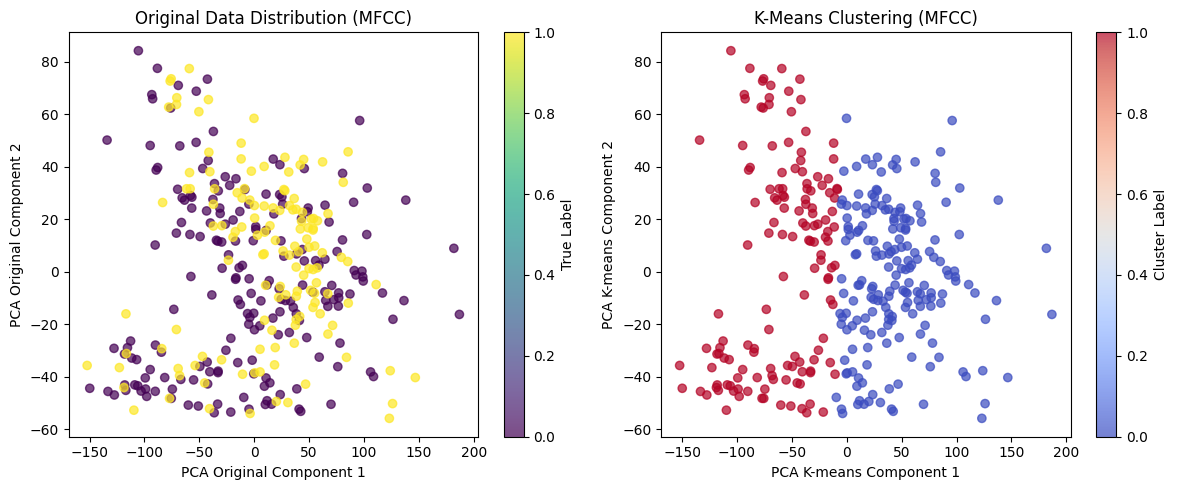

K-Means Clustering Accuracy (Mel Spectrogram): 0.5897


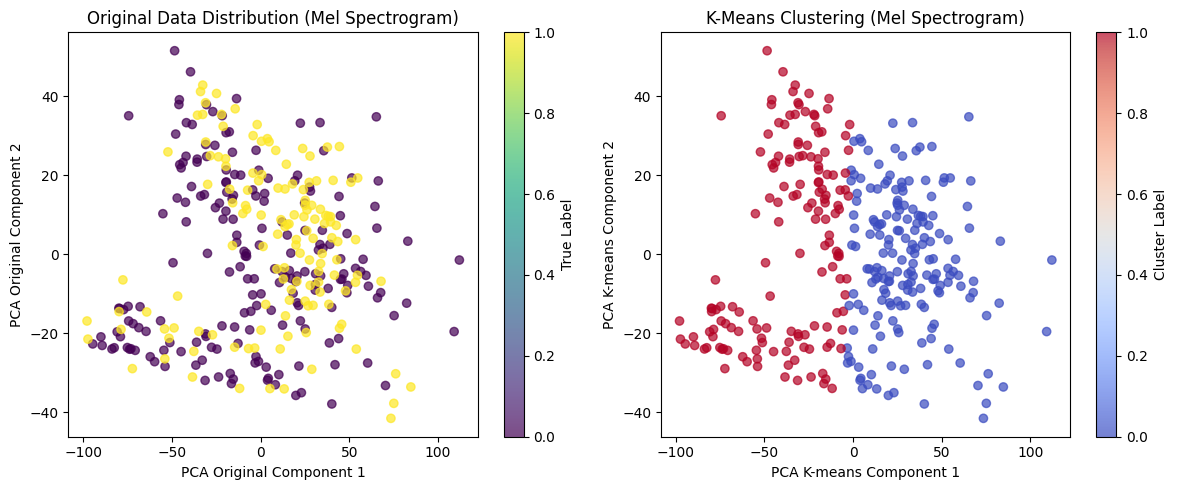

K-Means Clustering Accuracy (ZCR): 0.5228


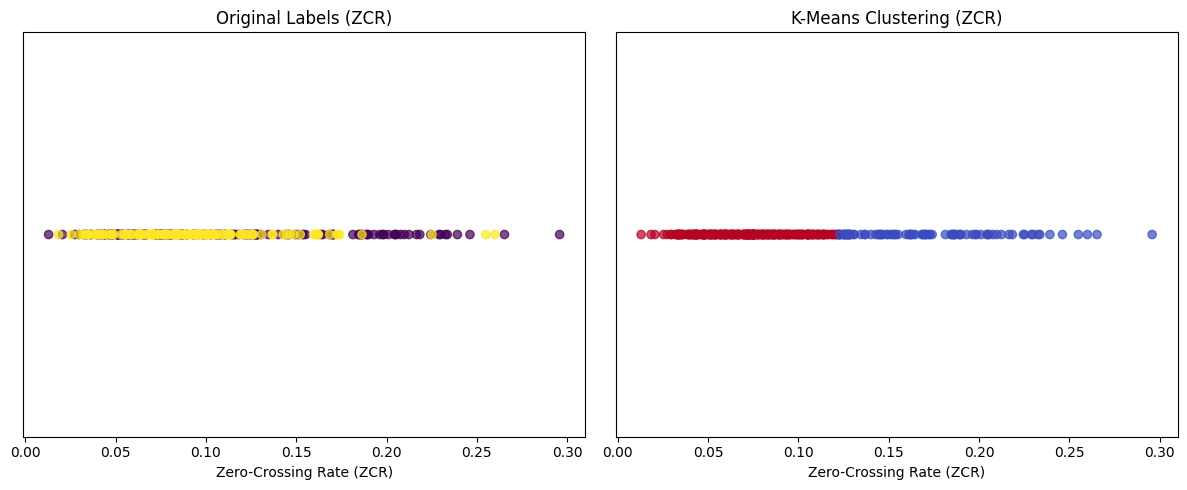


Final Comparison of K-Means Clustering Accuracy:
MFCC Accuracy: 0.5684
Mel Spectrogram Accuracy: 0.5897
ZCR Accuracy: 0.5228


In [24]:
acc_mfcc = kmeans_clustering_PCA(X_mfcc, y_mfcc, "MFCC")
acc_mel = kmeans_clustering_PCA(X_mel, y_mel, "Mel Spectrogram")
acc_zcr = kmeans_clustering_ZCR(X_zcr, y_zcr)
print("\nFinal Comparison of K-Means Clustering Accuracy:")
print(f"MFCC Accuracy: {acc_mfcc:.4f}")
print(f"Mel Spectrogram Accuracy: {acc_mel:.4f}")
print(f"ZCR Accuracy: {acc_zcr:.4f}")